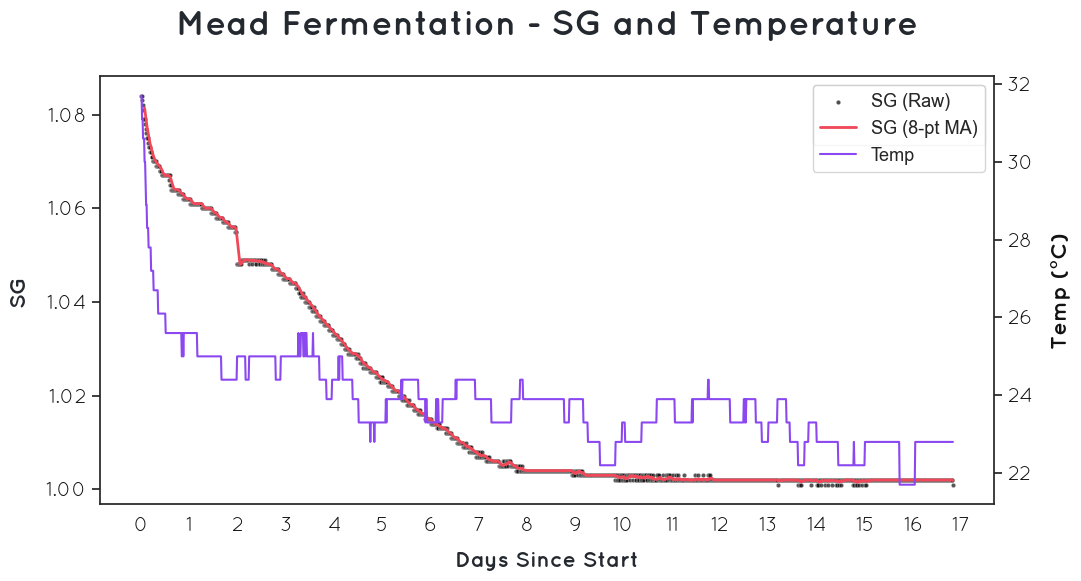

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

# --------------------------------------------------------------------
# Read CSV, parse dates, set index, etc.
# --------------------------------------------------------------------
df = pd.read_csv(
    "mead.csv",
    parse_dates=["Timepoint"],
)
df.set_index("Timepoint", inplace=True)
df.sort_index(inplace=True)

# Resample every 15 minutes and compute mean
df_15min = df.resample("15min").mean()

# Forward-fill missing intervals
df_15min_filled = df_15min.ffill()

# Rolling average (e.g., 8-point)
df_15min_filled["SG_MA_8"] = df_15min_filled["SG"].rolling(window=8).mean()

# Convert index to "DaysSinceStart"
t0 = df_15min_filled.index[0]
df_15min_filled["DaysSinceStart"] = (
    (df_15min_filled.index - t0).total_seconds() / 86400.0
)

# --------------------------------------------------------------------
# Fonts & Styling
# --------------------------------------------------------------------
TitleFont = fm.FontProperties(fname='Quicksand-Bold.otf', size=25)
AxisFont  = fm.FontProperties(fname='Quicksand-Bold.otf', size=16)
TicksFont = fm.FontProperties(fname='Quicksand-Regular.otf', size=15)

sns.set_theme()
sns.set_style('white')  # could be darkgrid, whitegrid, etc.

plt.rc('axes', titlesize=60)
plt.rc('axes', labelsize=40)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=13)
plt.rc('font', size=13)

# --------------------------------------------------------------------
# Plot Setup
# --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 6))

# Scatter plot of the original SG data
sns.scatterplot(
    x="DaysSinceStart",
    y="SG",
    data=df_15min_filled,
    ax=ax,
    color="#111111",   # your color
    alpha=0.7,
    s=10,              # marker size
    label="SG (Raw)"
)

# Line plot of the rolling average
sns.lineplot(
    x="DaysSinceStart",
    y="SG_MA_8",
    data=df_15min_filled,
    ax=ax,
    color="#f04859",
    linewidth=2,
    label="SG (8-pt MA)"
)

# Plot temperature on secondary axis
ax2 = ax.twinx()
sns.lineplot(
    x="DaysSinceStart",
    y="Temp (°C)",
    data=df_15min_filled,
    ax=ax2,
    color="#8B48F0",
    label="Temp"
)
ax2.set_ylabel(
    "Temp (°C)", 
    labelpad=12, 
    weight="bold", 
    fontproperties=AxisFont, 
    color="#111111"
)

# --------------------------------------------------------------------
# Title & Axis Labels
# --------------------------------------------------------------------

ax.set_title(
    "Mead Fermentation - SG and Temperature", 
    pad=30,
    weight="bold", 
    fontproperties=TitleFont, 
    color="#242930"
)

ax.set_xlabel(
    "Days Since Start",
    labelpad=12,
    weight="bold",
    fontproperties=AxisFont,
    color="#242930"
)

ax.set_ylabel(
    "SG",
    labelpad=12,
    weight="bold",
    fontproperties=AxisFont,
    color="#242930"
)

# --------------------------------------------------------------------
# Customize X-Axis Ticks as Day 0, Day 1, etc.
# --------------------------------------------------------------------
max_day = df_15min_filled["DaysSinceStart"].max()
xtick_values = range(0, int(np.floor(max_day)) + 2)  # day 0 up to max+1
ax.set_xticks(xtick_values)
ax.set_xticklabels([f"{d}" for d in xtick_values])

# --------------------------------------------------------------------
# Hide axis lines
# --------------------------------------------------------------------
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# --------------------------------------------------------------------
# Ticks styling
# --------------------------------------------------------------------
for label in ax.get_xticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#111111")

for label in ax.get_yticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#111111")

for label in ax2.get_yticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#111111")

# --------------------------------------------------------------------
# Combine Legends for both axes
# --------------------------------------------------------------------
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.show()

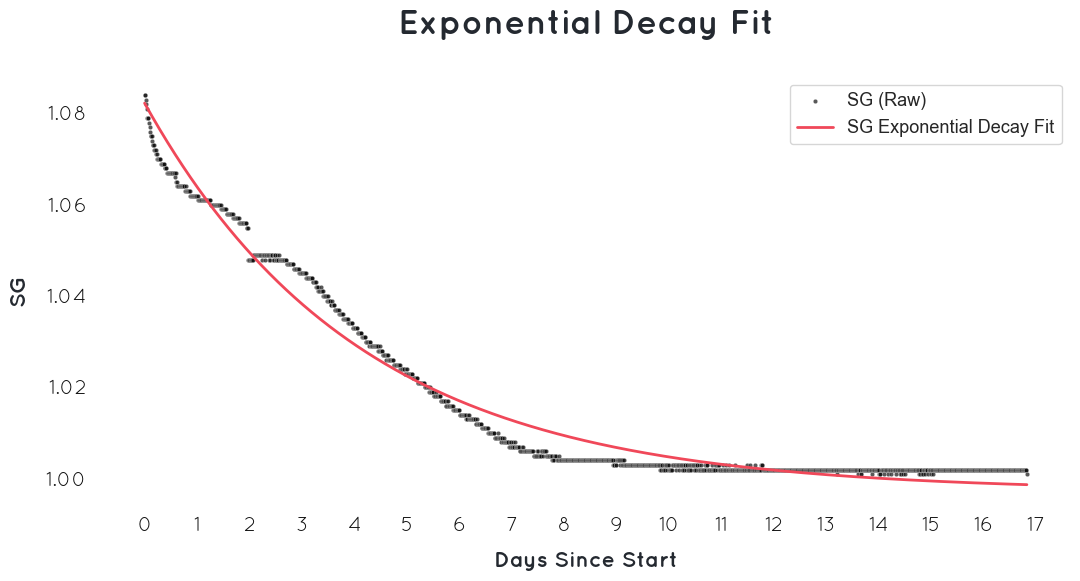

In [2]:
from scipy.optimize import curve_fit

# -------------------------------------------------------------------
# Exponential Decay Fit
#    SG(t) = FG + (OG - FG) * exp(-k * t)
# -------------------------------------------------------------------
def exp_decay(t, OG, FG, k):
    return FG + (OG - FG) * np.exp(-k*t)

# Provide initial guesses: 
# - OG ~ first data point
# - FG ~ last data point (or 1.0 if you suspect dryness)
# - k  ~ small positive number
p0 = [df_15min_filled["SG"].iloc[0], 1.0, 0.05]

popt, pcov = curve_fit(exp_decay, df_15min_filled["DaysSinceStart"], df_15min_filled["SG"], p0=p0)
OG_fit, FG_fit, k_fit = popt
sg_exp = exp_decay(df_15min_filled["DaysSinceStart"], *popt)

# --------------------------------------------------------------------
# Plot Setup
# --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 6))

# Scatter plot of the original SG data
sns.scatterplot(
    x="DaysSinceStart",
    y="SG",
    data=df_15min_filled,
    ax=ax,
    color="#111111",   # your color
    alpha=0.7,
    s=10,              # marker size
    label="SG (Raw)"
)

# Line plot of exponential decay fit
sns.lineplot(
    x="DaysSinceStart",
    y=sg_exp,
    data=df_15min_filled,
    ax=ax,
    color="#f04859",
    linewidth=2,
    label="SG Exponential Decay Fit"
)

# --------------------------------------------------------------------
# Title & Axis Labels
# --------------------------------------------------------------------

ax.set_title(
    "Exponential Decay Fit", 
    pad=30,
    weight="bold", 
    fontproperties=TitleFont, 
    color="#242930"
)

ax.set_xlabel(
    "Days Since Start",
    labelpad=12,
    weight="bold",
    fontproperties=AxisFont,
    color="#242930"
)

ax.set_ylabel(
    "SG",
    labelpad=12,
    weight="bold",
    fontproperties=AxisFont,
    color="#242930"
)

# --------------------------------------------------------------------
# Customize X-Axis Ticks as Day 0, Day 1, etc.
# --------------------------------------------------------------------
max_day = df_15min_filled["DaysSinceStart"].max()
xtick_values = range(0, int(np.floor(max_day)) + 2)  # day 0 up to max+1
ax.set_xticks(xtick_values)
ax.set_xticklabels([f"{d}" for d in xtick_values])

# --------------------------------------------------------------------
# Hide axis lines
# --------------------------------------------------------------------
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# --------------------------------------------------------------------
# Ticks styling
# --------------------------------------------------------------------
for label in ax.get_xticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#111111")

for label in ax.get_yticklabels():
    label.set_fontproperties(TicksFont)
    label.set_color("#111111")

# --------------------------------------------------------------------
# Combine Legends for both axes
# --------------------------------------------------------------------
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.show()

In [3]:
print(OG_fit, FG_fit, k_fit)

1.0822373854845213 0.9972545822901815 0.2428176807143304
